# Historical Return Distributions
## Analysis to determine how historical returns are distributed

Better understanding the distribution of past returns is critical to creating simulations. 
In the case of bitcoin, returns do not seem to be normally distributed so let's test the historical returns against a series of available numpy distributions.
Then test the best fit.

In [143]:
# Import Libraries
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot

import urllib
import requests
import riskfolio as rp
from datetime import datetime, timedelta
from copy import deepcopy

from highcharts import Highchart
from chart_builder import plot_chart, CHART_DEFAULTS
from IPython.display import display, HTML, display_html
import import_ipynb

# Chart libraries + settings
# plt.style.use('seaborn-whitegrid')
pd.options.mode.chained_assignment = None  # default='warn' - disable some pandas warnings
pd.options.display.float_format = '{:,.2f}'.format


In [143]:
# MatPlotLib settings
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from cycler import cycler

# Swan Colors
swan_colors = ['#31597F', '#7B96B0', '#C3D9E9', '#DAE1E8']
mpl.rcParams['lines.color'] = '#31597F'
mpl.rcParams['text.color'] = '#31597F'
mpl.rcParams['axes.prop_cycle'] = cycler(color=swan_colors)
mpl.rcParams['lines.linewidth'] = 1
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
sns.color_palette('pastel')
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=8)   
plt.rc('xtick', labelsize=8, color='#00305E')  
plt.rc('ytick', labelsize=8, color='#00305E')    
plt.rc('legend', fontsize=12)
plt.rc('font', size=8)          

import matplotlib.ticker as ticker

# Define the formatter
formatter = ticker.StrMethodFormatter('{x:,.2f}')


import matplotlib.image as mpimg

# Read in the image file
watermark = mpimg.imread('swan-icon-snow.png')

# Display the image as a background
# plt.figimage(watermark, alpha=0.2, zorder=-1)

# Use the formatter on the y-axis
# plt.gca().yaxis.set_major_formatter(formatter)

# plt.figure(figsize=(10, 10), tight_layout=True)


In [144]:
# Load Bitcoin Prices into a dataframe
# Ticker is customizable
ticker = "BTC"
# Cryptocompare URL and fiels
base_url = 'https://min-api.cryptocompare.com/data/histoday'
ticker_field = 'fsym'
field_dict = {'tsym': 'USD','allData': 'true'}
# Convert the field dict into a url encoded string
url_args = "&" + urllib.parse.urlencode(field_dict)
ticker = ticker.upper()
globalURL = (base_url + "?" + ticker_field + "=" + ticker + url_args)

In [145]:
# Request the data
resp = requests.get(url=globalURL)
data = resp.json()
data["Response"]

'Success'

In [146]:
# Parse the JSON into a Pandas DataFrame
try:
    df = pd.DataFrame.from_dict(data['Data'])
    df = df.rename(columns={'time': 'date'})
    df['date'] = pd.to_datetime(df['date'], unit='s')
    df.set_index('date', inplace=True)
    df_save = df[['close', 'open', 'high', 'low']]
except Exception as e:
    print(e)
    df_save = None

In [147]:
# Include percentage change 
df['change'] = df['close'].pct_change()

In [148]:
df

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,change
date,,,,,,,,,
2010-07-17,0.05,0.05,0.05,20.00,0.99,0.05,direct,,NaN
2010-07-18,0.09,0.06,0.05,75.01,5.09,0.09,direct,,0.73
2010-07-19,0.09,0.08,0.09,574.00,49.66,0.08,direct,,-0.06
2010-07-20,0.08,0.07,0.08,262.00,20.59,0.07,direct,,-0.07
2010-07-21,0.08,0.07,0.07,575.00,42.26,0.08,direct,,0.06
...,...,...,...,...,...,...,...,...,...
2023-05-23,"27,475.27","26,808.48","26,855.83","21,224.55","578,325,164.30","27,224.64",direct,,0.01
2023-05-24,"27,225.94","26,088.24","27,224.64","31,288.65","828,809,867.37","26,326.59",direct,,-0.03
2023-05-25,"26,600.00","25,879.36","26,326.59","22,738.60","598,005,506.21","26,480.31",direct,,0.01


#### We can calculate the statistical properties of the 'change' column, including skewness and kurtosis. Skewness measures the symmetry in a distribution, while kurtosis measures the tail. If skewness is close to 0, the dataset is roughly symmetric. If kurtosis is close to 3, the dataset is roughly bell-shaped.

In [149]:
change = df['change']
print(f"Mean: {change.mean()}, Standard Deviation: {change.std()}")
print(f"Skewness: {change.skew()}, Kurtosis: {change.kurt()}")


Mean: 0.0047765039790446445, Standard Deviation: 0.07539538495097965
Skewness: 20.267968300211763, Kurtosis: 866.4429211767966


Let's calculate the logarithmic returns. Logarithmic returns are generally used when returns are continuously compounded. They are also more convenient for mathematical modeling because of their time-additive property, which means the multi-period log return is the sum of single-period log returns.



In [150]:
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

In [151]:
# Function to Calculate Rolling Returns
def calculate_rolling_returns(df, n):
    """
    This function calculates the n-days rolling returns
    """
    df[f'{n}_day_rolling_return'] = df['log_return'].rolling(n).sum()
    return df


#### Plot the Historical Distribution of n-days
The issue of using 1-day returns is that there is probably autocorrelation of returns. For monte carlo simulations, it will be important to find a period of returns where this auto-correlation is stable. We'll test a few periods.

For this cell, let's assume n=5, i.e., we're looking at weekly returns. You can change this to any number you'd like.

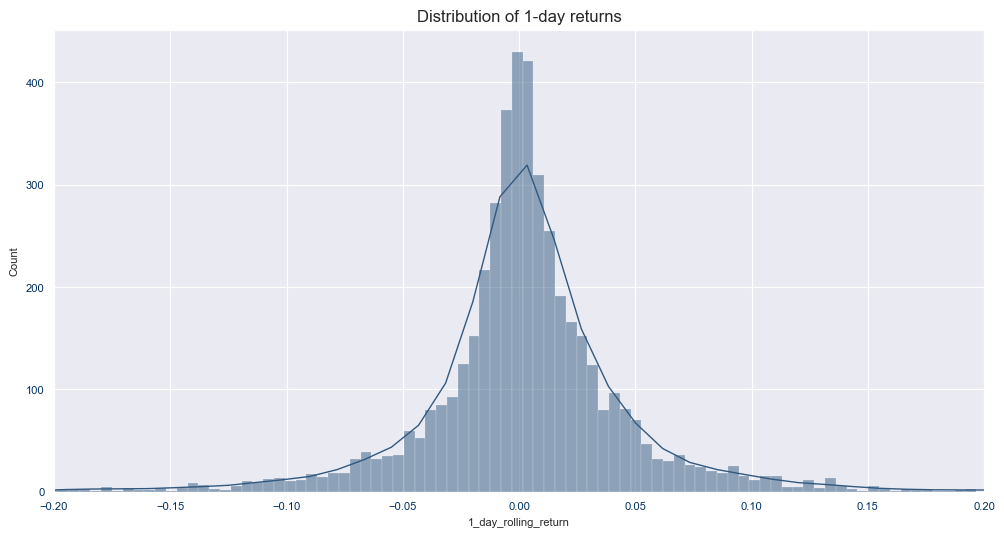

In [292]:
n = 1
df = calculate_rolling_returns(df, n)
plt.figure(figsize=(12,6))
sns.histplot(data=df, x=f'{n}_day_rolling_return', kde=True, bins=500)
plt.title(f"Distribution of {n}-day returns")

plt.xlim(-0.2, 0.2)



plt.show()


#### Comparing with theoretical distributions
We're going to compare our n-day returns with a few different theoretical distributions: normal, log-normal, and t-distribution.

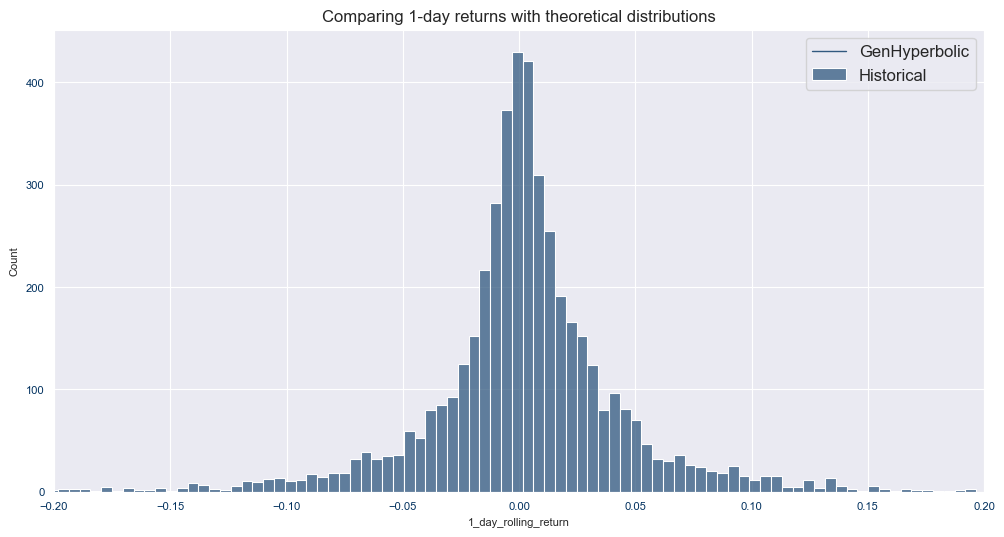

In [300]:
# Create a series of data points in the range of our returns
x = np.linspace(df[f'{n}_day_rolling_return'].min(), df[f'{n}_day_rolling_return'].max(), 100)

# Create the normal distribution for the given mean and standard deviation
norm_pdf = stats.norm.pdf(x, df[f'{n}_day_rolling_return'].mean(), df[f'{n}_day_rolling_return'].std())

# Create the log-normal distribution
lognorm_pdf = stats.lognorm.pdf(x, df[f'{n}_day_rolling_return'].std(), scale=np.exp(df[f'{n}_day_rolling_return'].mean()))

# Create the t distribution
t_pdf = stats.t.pdf(x, df[f'{n}_day_rolling_return'].std(), df[f'{n}_day_rolling_return'].mean(), df[f'{n}_day_rolling_return'].std())

# Create a genhyperbolic distribution
genhyperbolic_pdf = stats.genhyperbolic.pdf(x, df[f'{n}_day_rolling_return'].std(), df[f'{n}_day_rolling_return'].mean(), df[f'{n}_day_rolling_return'].std())

# Plot all these distributions
plt.figure(figsize=(12,6))
plt.xlim(-0.2, 0.2)
sns.histplot(data=df, x=f'{n}_day_rolling_return', bins=500, label="Historical")
plt.plot(x, genhyperbolic_pdf, label="GenHyperbolic")
plt.title(f"Comparing {n}-day returns with theoretical distributions")
plt.legend()
plt.show()


#### Quantile-Quantile Plot
To visualize how well our data fits a theoretical distribution, we can use a Quantile-Quantile plot. This plot should show the data following along a straight line if the data follows the theoretical distribution.

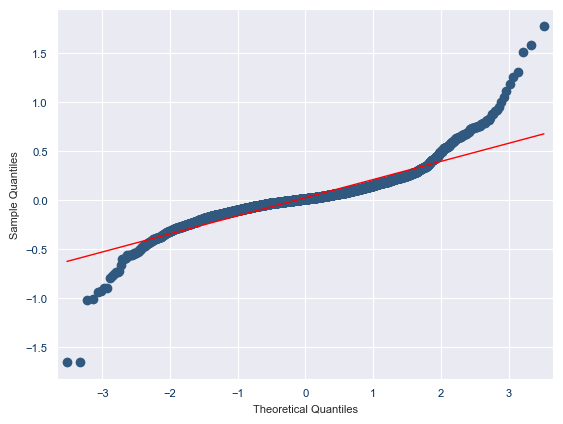

In [208]:
# We are comparing it with normal distribution here
qqplot(df[f'{n}_day_rolling_return'].dropna(), line='s')

plt.show()

#### Goodness of Fit Tests
We'll use the Kolmogorov-Smirnov test, which is a nonparametric test that compares a sample with a reference probability distribution (one-sample K-S test), or compares two samples (two-sample K-S test).

This will give you a table with the K-S statistic and p-value for each distribution. The K-S statistic is a measure of the distance between the empirical distribution function of the data and the cumulative distribution function of the reference distribution, or between the empirical distribution functions of two samples. The smaller the K-S statistic, the better the fit. The p-value can be used to decide whether to reject the null hypothesis that the data follows the given distribution. If the p-value is high (close to 1), we cannot reject the hypothesis that the data follows the given distribution.

In [ ]:
dist_names = ['alpha', 'anglit', 'arcsine', 'argus', 'beta', 'betaprime', 
              'bradford', 'burr', 'burr12', 'cauchy', 'chi', 'chi2', 'cosine', 
              'crystalball', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponnorm', 
              'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 
              'foldnorm', 'genlogistic', 'gennorm', 'genpareto', 'genexpon', 
              'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 
              'genhyperbolic', 'geninvgauss', 'gibrat', 'gompertz', 'gumbel_r', 'gumbel_l', 
              'halfcauchy', 'halflogistic', 'halfnorm', 'halfgennorm', 'hypsecant', 
              'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'kappa4', 
              'kappa3', 'ksone', 'kstwobign', 'laplace', 'laplace_asymmetric', 
              'levy', 'levy_l', 'logistic', 'loggamma', 'loglaplace', 
              'lognorm', 'lomax', 'maxwell', 'mielke', 'moyal', 'nakagami', 
              'ncx2', 'ncf', 'norm', 'norminvgauss', 'pareto', 'pearson3', 
              'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'rayleigh', 'rice', 
              'recipinvgauss', 'semicircular', 'skewcauchy', 'skewnorm', 
              't', 'trapezoid', 'triang', 'truncexpon', 
              'truncnorm', 'truncpareto', 'truncweibull_min', 'tukeylambda', 'uniform', 
              'vonmises', 'vonmises_line', 'wald', 'weibull_min', 'weibull_max', 
              'wrapcauchy']


results = []
gen_store = None

for dist_name in dist_names:
    dist = getattr(stats, dist_name)
    param = dist.fit(df[f'{n}_day_rolling_return'].dropna())
    a = stats.kstest(df[f'{n}_day_rolling_return'].dropna(), dist_name, args=param)
    results.append((dist_name, a[0], a[1]))
    if dist_name == 'genhyperbolic':
        print(a)
        gen_store = a

results_df = pd.DataFrame(results, columns=['Distribution', 'KS Statistic', 'P-Value'])
results_df


In [272]:
# sort df 
results_df.sort_values(by=['P-Value'], ascending=False, inplace=True)
results_df.head(10)

,Distribution,KS Statistic,P-Value
35,genhyperbolic,0.01,0.53
71,norminvgauss,0.02,0.18
50,johnsonsu,0.02,0.13
56,laplace_asymmetric,0.02,0.01
27,gennorm,0.03,0.00
91,tukeylambda,0.03,0.00
15,dweibull,0.03,0.00
84,t,0.03,0.00
14,dgamma,0.03,0.00
55,laplace,0.04,0.00


#### Seems like genhyperbolic is the best fit by far

In [186]:
gen_store

KstestResult(statistic=0.011792361434555643, pvalue=0.5282315385586679, statistic_location=0.031334933195161466, statistic_sign=1)

With the exception of genhyperbolic curve, it doesn't seem like any of the distributions above do a good job of predicting prices.

In finance, it's often observed that large changes in prices tend to be followed by more large changes—this is known as "volatility clustering". The opposite is also true; periods of small changes tend to be followed by periods of small changes. Additionally, financial data often exhibit "leverage effects", meaning that volatility tends to increase more when the price of an asset decreases than when the price of the asset increases.

#### GARCH Model

To model these effects above, we can use a class of models known as GARCH (Generalized Autoregressive Conditional Heteroskedasticity) models. In a GARCH model, the variance of the residuals is assumed to follow an autoregressive process, which allows the model to capture the volatility clustering effect.

In [71]:
from arch import arch_model

#### Specify and Fit the GARCH model
We'll first specify a simple GARCH(1, 1) model. The numbers 1, 1 represent the order of the GARCH and ARCH components of the model.

In [72]:
# Specify the model
garch_model = arch_model(df[f'{n}_day_rolling_return'].dropna(), vol='Garch', p=1, q=1)

# Fit the model
garch_results = garch_model.fit(update_freq=5)

# Print the summary of results
print(garch_results.summary())


Optimization terminated successfully    (Exit mode 0)
            Current function value: -8254.238995801576
            Iterations: 7
            Function evaluations: 34
            Gradient evaluations: 3
                      Constant Mean - GARCH Model Results                       
Dep. Variable:     1_day_rolling_return   R-squared:                       0.000
Mean Model:               Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GARCH   Log-Likelihood:                8254.24
Distribution:                    Normal   AIC:                          -16500.5
Method:              Maximum Likelihood   BIC:                          -16474.7
                                          No. Observations:                 4697
Date:                  Sat, May 27 2023   Df Residuals:                     4696
Time:                          09:47:52   Df Model:                            1
                                 Mean Model                    

/Users/zagury/Documents/Swan/Coding/allocation_strategies/.myenv/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003568. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


#### Check Residuals and Squared Residuals
The residuals and squared residuals of a well-specified GARCH model should resemble white noise, i.e., they should be uncorrelated and have a constant mean and variance. We can plot the residuals and squared residuals to check this.

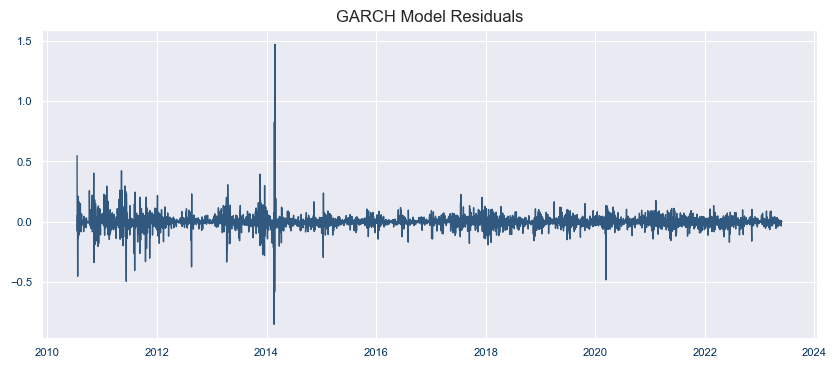

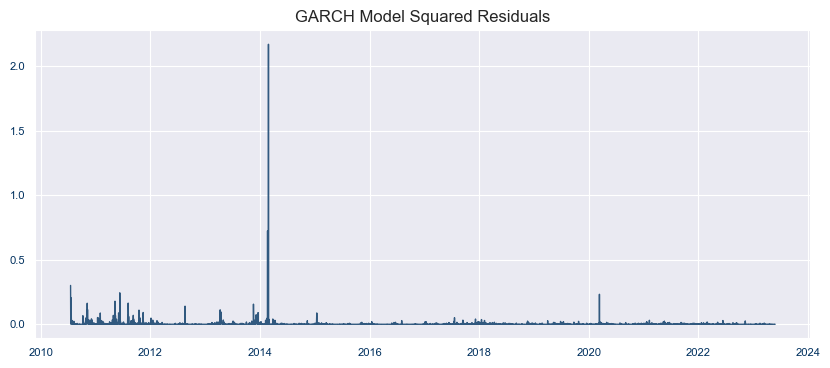

In [73]:
# Residuals 
plt.figure(figsize=(10,4))
plt.plot(garch_results.resid)
plt.title("GARCH Model Residuals")

# Squared Residuals
plt.figure(figsize=(10,4))
plt.plot(garch_results.resid**2)
plt.title("GARCH Model Squared Residuals")
plt.show()


#### Test for Autocorrelation

To formally test for autocorrelation in the residuals and squared residuals, we can use the Ljung-Box test.

If the p-values are greater than a given significance level (say 0.05), we do not reject the null hypothesis that the residuals are independently distributed, indicating that the GARCH model is a good fit.

> Remember that GARCH models can be quite flexible and may be able to capture the properties of your returns data better than a simple statistical distribution. However, they also come with their own set of assumptions and challenges, and their suitability should be assessed based on a comprehensive evaluation of your data and the specific questions you are trying to answer.

In [76]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_results = acorr_ljungbox(garch_results.resid, lags=30)
print(f"Ljung-Box test statistic: {ljung_box_results.lb_stat}")
print(f"Ljung-Box test p-value: {ljung_box_results.lb_pvalue}")

ljung_box_results_squared = acorr_ljungbox(garch_results.resid**2, lags=30)
print(f"Ljung-Box test statistic for squared residuals: {ljung_box_results_squared.lb_stat}")
print(f"Ljung-Box test p-value for squared residuals: {ljung_box_results_squared.lb_pvalue}")


Ljung-Box test statistic: 1      0.91
2     92.24
3     92.24
4    144.50
5    177.58
6    183.04
7    193.77
8    194.51
9    194.74
10   196.55
11   199.38
12   199.39
13   200.25
14   201.87
15   201.94
16   201.94
17   205.98
18   206.17
19   206.17
20   207.21
21   207.66
22   212.74
23   215.14
24   215.20
25   215.70
26   215.99
27   219.29
28   221.17
29   225.30
30   225.49
Name: lb_stat, dtype: float64
Ljung-Box test p-value: 1    0.34
2    0.00
3    0.00
4    0.00
5    0.00
6    0.00
7    0.00
8    0.00
9    0.00
10   0.00
11   0.00
12   0.00
13   0.00
14   0.00
15   0.00
16   0.00
17   0.00
18   0.00
19   0.00
20   0.00
21   0.00
22   0.00
23   0.00
24   0.00
25   0.00
26   0.00
27   0.00
28   0.00
29   0.00
30   0.00
Name: lb_pvalue, dtype: float64
Ljung-Box test statistic for squared residuals: 1       11.68
2      279.49
3      286.06
4      687.63
5      691.74
6      999.45
7    1,001.32
8    1,002.05
9    1,002.97
10   1,005.59
11   1,006.79
12   1,007.05
13   1,007.9

Some initial conclusions given the data:

. The Ljung-Box test checks whether there is evidence of autocorrelation at a given number of lags. The null hypothesis for this test is that the data are independently distributed. Low p-values (usually less than 0.05) mean that you can reject the null hypothesis and therefore conclude that the data are not independently distributed and there is evidence of autocorrelation.

. Looking at results, the p-values are all less than 0.05 for all lags except for the very first one, suggesting that we can reject the null hypothesis of no autocorrelation in the data.

. Furthermore, the Ljung-Box statistic tends to increase as we increase the number of lags. This can be seen in both the standard residuals and squared residuals. This is a sign that there is significant autocorrelation in the data at multiple lag levels.

. <strong>Overall, these results strongly suggest that the returns of bitcoin data exhibit autocorrelation. </strong>

. This is not unusual in financial time series data, and in fact, this is exactly the kind of behavior that the GARCH model is designed to handle. Autocorrelation in the volatility (which would be represented in the squared residuals) is particularly well suited for GARCH modeling, as the model explicitly models volatility clustering.

. In the case of this output, it seems that after around 10 lags, the Ljung-Box statistic starts to increase more slowly, suggesting that adding more lags beyond that point doesn't provide much additional information about autocorrelation in your data.

> While GARCH models can be very effective in modeling the volatility of financial data, it's important to note that GARCH models, by themselves, are not designed to predict the actual prices of assets, rather, they predict volatility. Volatility is a measure of the dispersion of returns for a given asset and is key to various investment and trading strategies. High volatility is associated with higher risk, but also the potential for higher returns.

#### ARIMA Modeling
ARIMA stands for AutoRegressive Integrated Moving Average. This model captures a suite of different standard temporal structures in time series data.

In the cell below, we will calculate the returns of the Bitcoin price data, and then split the data into a training set (80% of the data) and a test set (the remaining 20%). Then, we fit an ARIMA model to the training data. The parameters (5,1,0) are the order of the AR, I, and MA components respectively -- these can be tuned. We've chosen a simple ARIMA(5,1,0) model as a starting point.


In [86]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# If 'date' is the column with your dates
df.index = pd.to_datetime(df.index)
df.index = df.index.to_period('D')

# Convert the series to returns
returns = df['close'].pct_change().dropna()

# Split the data into training and testing data
size = int(len(returns) * 0.8)
train, test = returns[0:size], returns[size:len(returns)]

# Fit the ARIMA model
model_arima = ARIMA(train, order=(5,1,0)) 
model_fit = model_arima.fit()


In [87]:
# Predict the future returns
# Once you run this cells, you should see the RMSE for the ARIMA model. 
# If the RMSE is low, it indicates that the ARIMA model is a good fit 
# for the data and is accurately predicting future returns.

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE (Root Mean Squared Error)
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.037


In [ ]:
# In the next step, we will fit a GARCH model to the residuals 
# of the ARIMA model to predict future volatility.
# Let's first calculate the residuals and then fit the GARCH model.

# Calculate the residuals
residuals = pd.DataFrame(model_fit.resid)

# Fit the GARCH model
from arch import arch_model
model_garch = arch_model(residuals, vol='Garch', p=1, q=1)
model_garch_fit = model_garch.fit(disp='off')


In [ ]:
# We are calculating the residuals from the ARIMA model 
# (which is the difference between the actual returns and 
# the predicted returns) and then fitting a GARCH model to 
# these residuals.

# Next, we will use the GARCH model to predict future volatility.

# Predict the future volatility
volatility = model_garch_fit.forecast(start=0).variance
volatility = volatility.iloc[-1, 0]
print('Predicted volatility: %.3f' % volatility)


## Using historical returns to predict future returns

Let's use now historical returns as a way to predict future returns. We'll create a histogram up to a certain date and then check if that would have been a good predictor of future returns.

It does seem from the analysis above that using 10-day periods may be ideal. This is where the autocorrelation using GARCH tests seem to start to increase at smaller increments. 

In [301]:
from scipy.stats import genhyperbolic, norm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

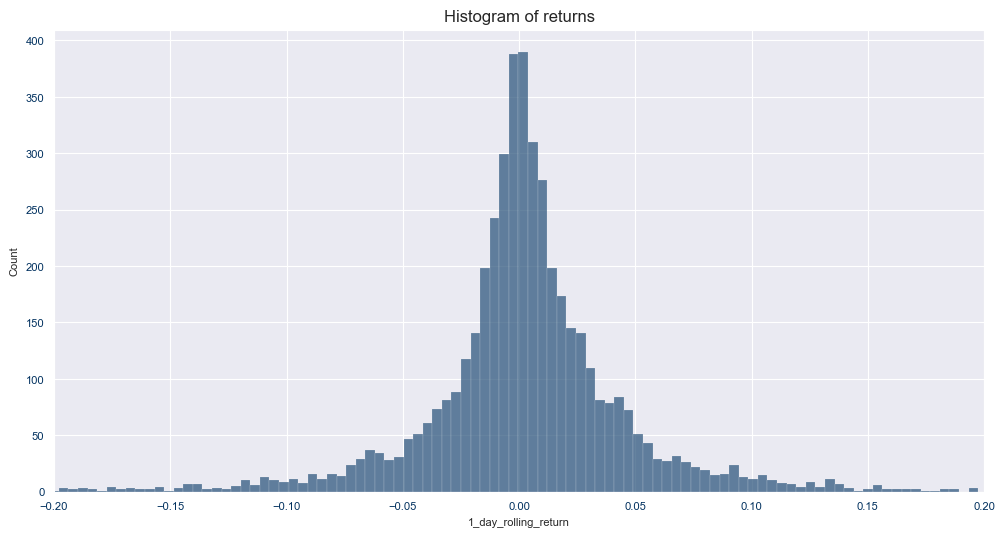

In [283]:
plt.figure(figsize=(12,6))
sns.histplot(df[f'{n}_day_rolling_return'], kde=False)
plt.title('Histogram of returns')
plt.xlim(-0.2, 0.2)
plt.show()

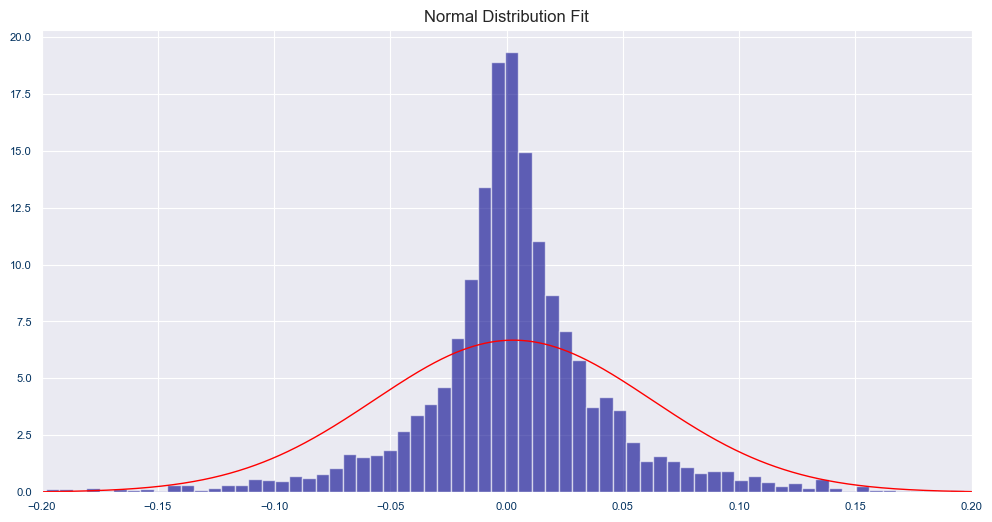

In [304]:
# Drop any NaN from the data first
returns = df[f'{n}_day_rolling_return'].dropna()

params = norm.fit(returns)

# Get the fitted PDF
x = np.linspace(min(returns), max(returns), 10000)
pdf_fitted = norm.pdf(x, *params)
plt.figure(figsize=(12,6))
plt.hist(returns, density=True, bins=400, alpha=0.6, color='darkblue')
plt.plot(x, pdf_fitted, 'r')
# start x-axis at 0
plt.xlim(-0.2, 0.2)
plt.title('Normal Distribution Fit')
plt.show()


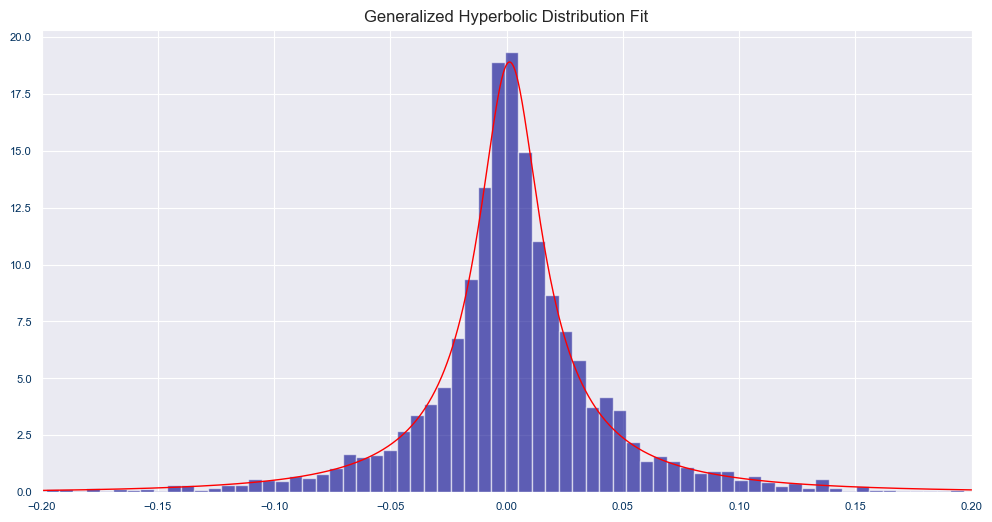

In [285]:
# Drop any NaN from the data first
returns = df[f'{n}_day_rolling_return'].dropna()

params = genhyperbolic.fit(returns)

# Get the fitted PDF
x = np.linspace(min(returns), max(returns), 10000)
pdf_fitted = genhyperbolic.pdf(x, *params)
plt.figure(figsize=(12,6))
plt.hist(returns, density=True, bins=400, alpha=0.6, color='darkblue')
plt.plot(x, pdf_fitted, 'r')
# start x-axis at 0
plt.xlim(-0.2, 0.2)
plt.title('Generalized Hyperbolic Distribution Fit')
plt.show()


In [236]:
params

(-0.15620591650193102,
 0.28231329808533023,
 0.04472318305611227,
 0.00733218928924152,
 0.07053382919269727)

In [237]:
D, p_value = stats.kstest(returns, 'genhyperbolic', args=params)
print('p-value: ', p_value)


p-value:  0.5282315385586679


### Run the Monte Carlo Simulations

Simulation based on the genhyperbolic distribution:

In [238]:
n_sims = 1000
n_days = 252  # number of trading days in a year

sim_returns_gh = genhyperbolic.rvs(*params, size=(n_days, n_sims))

# Convert returns to price assuming starting price of 1
sim_prices_gh = np.cumprod(1 + sim_returns_gh, axis=0)


Simulation based on historical returns distribution:

In [239]:
sim_returns_hist = np.random.choice(returns, size=(n_days, n_sims))

# Convert returns to price
sim_prices_hist = np.cumprod(1 + sim_returns_hist, axis=0)


#### Backtesting

Based on the results of the backtesting and the comparison of the RMSE of both methods,

you can make a decision on which method is more suitable for your specific use-case. 

If the RMSE of one method is significantly lower than the other, you may want to choose 

that method for future forecasts. 

In [305]:
tscv = TimeSeriesSplit(n_splits=20)

gh_scores = []
hist_scores = []

for train_index, test_index in tscv.split(returns):
    train, test = returns[train_index], returns[test_index]
    
    # genhyperbolic
    gh_params = genhyperbolic.fit(train)
    gh_predicted = genhyperbolic.rvs(*gh_params, size=len(test))
    gh_scores.append(mean_squared_error(test, gh_predicted))
    
    # historical
    hist_predicted = np.random.choice(train, size=len(test))
    hist_scores.append(mean_squared_error(test, hist_predicted))

print(f"genhyperbolic RMSE: {np.mean(np.sqrt(gh_scores))}")
print(f"Historical RMSE: {np.mean(np.sqrt(hist_scores))}")


genhyperbolic RMSE: 0.08694377540102013
Historical RMSE: 0.09530990742275999


## Monte Carlo Simulations

In [254]:
def generate_monte_carlo_simulations(df, n_sims, n_days):
    # Drop any NaN from the data first
    log_returns = df[f'{n}_day_rolling_return'].dropna()

    # GenHyperbolic distribution
    params = genhyperbolic.fit(log_returns)
    sim_log_returns_gh = genhyperbolic.rvs(*params, size=(n_days, n_sims))

    # Historical distribution
    sim_log_returns_hist = np.random.choice(log_returns, size=(n_days, n_sims))

    return sim_log_returns_gh, sim_log_returns_hist


In [255]:
def project_future_prices(last_price, sim_log_returns):
    # First, compute the cumulative log returns
    cumulative_log_returns = np.cumsum(sim_log_returns, axis=0)

    # Then exponentiate to get relative price changes
    relative_prices = np.exp(cumulative_log_returns)

    # Finally, multiply by the last price to get absolute prices
    sim_prices = last_price * relative_prices

    return sim_prices


In [264]:
n = 1
# Use log returns instead of arithmetic returns
df[f'{n}_day_rolling_return'] = np.log(df['close'] / df['close'].shift(n))

n_sims = 1000
n_days = 252  # for example, project one year into the future

sim_returns_gh, sim_returns_hist = generate_monte_carlo_simulations(df, n_sims, n_days)

last_price = df['close'][-1]

sim_prices_gh = project_future_prices(last_price, sim_returns_gh)
sim_prices_hist = project_future_prices(last_price, sim_returns_hist)


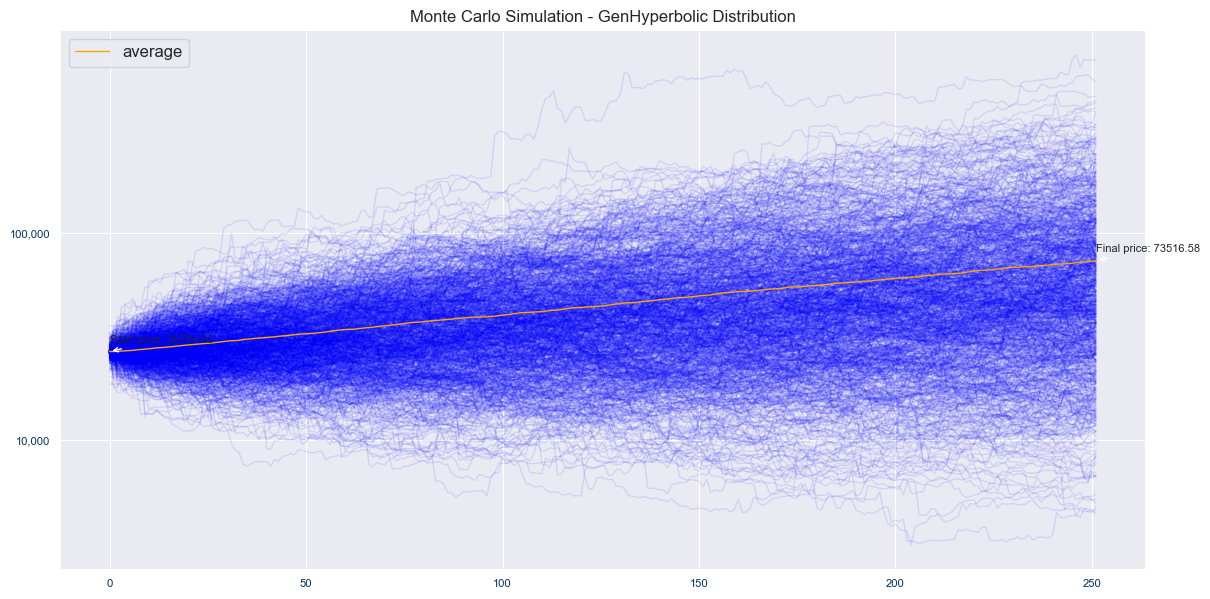

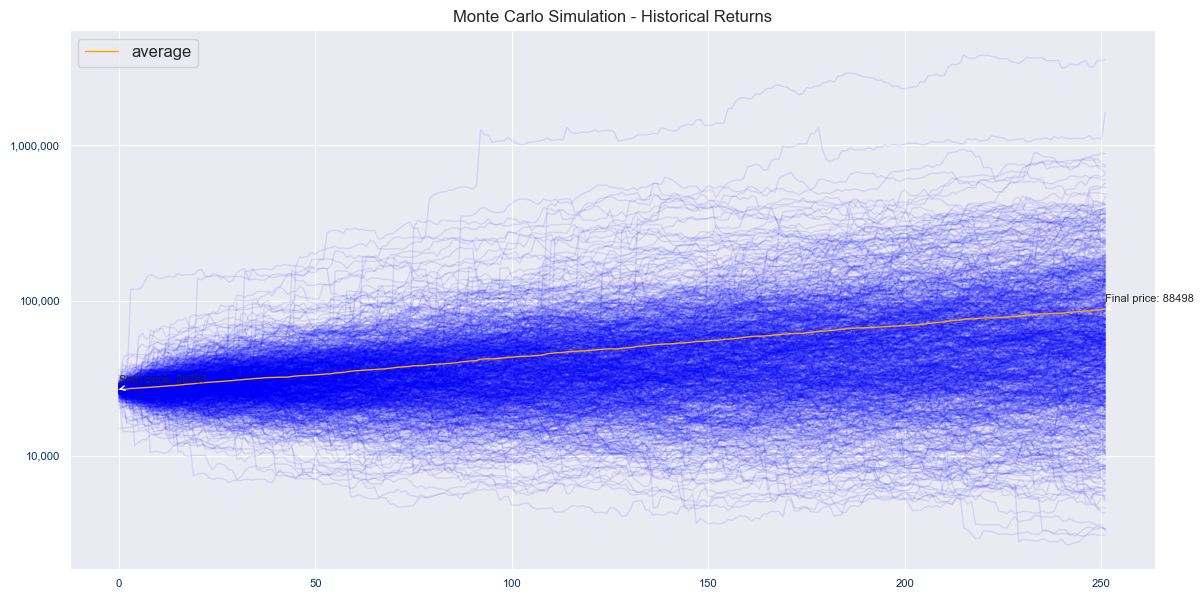

In [271]:
import matplotlib.ticker as ticker
# Formatter function
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
plt.figure(figsize=(14,7))

for i in range(n_sims):
    plt.plot(sim_prices_gh[:, i], color='blue', alpha=0.1)
plt.yscale('log')  # set the Y-axis to a logarithmic scale
# Add the average simulation path
avg_path_gh = sim_prices_gh.mean(axis=1)
plt.plot(avg_path_gh, color='orange', label='average')

# Add annotations for the start and final prices of the average path
start_price_gh = avg_path_gh[0]
final_price_gh = avg_path_gh[-1]
plt.annotate(f'Start price: {start_price_gh:.2f}', xy=(0, start_price_gh), xytext=(0, start_price_gh*1.1),
             arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.annotate(f'Final price: {final_price_gh:.2f}', xy=(n_days-1, final_price_gh), xytext=(n_days-1, final_price_gh*1.1),
             arrowprops=dict(facecolor='black', arrowstyle="->"))

plt.title('Monte Carlo Simulation - GenHyperbolic Distribution')
plt.legend()
# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

plt.figure(figsize=(14,7))
for i in range(n_sims):
    plt.plot(sim_prices_hist[:, i], color='blue', alpha=0.1)
plt.yscale('log')  # set the Y-axis to a logarithmic scale
# Add the average simulation path
avg_path_hist = sim_prices_hist.mean(axis=1)
plt.plot(avg_path_hist, color='orange', label='average')

# Add annotations for the start and final prices of the average path
start_price_hist = avg_path_hist[0]
final_price_hist = avg_path_hist[-1]
plt.annotate(f'Start price: {start_price_hist:.0f}', xy=(0, start_price_hist), xytext=(0, start_price_hist*1.1),
             arrowprops=dict(facecolor='black', arrowstyle="->"))
plt.annotate(f'Final price: {final_price_hist:.0f}', xy=(n_days-1, final_price_hist), xytext=(n_days-1, final_price_hist*1.1),
             arrowprops=dict(facecolor='black', arrowstyle="->"))

plt.title('Monte Carlo Simulation - Historical Returns')
plt.legend()
# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()


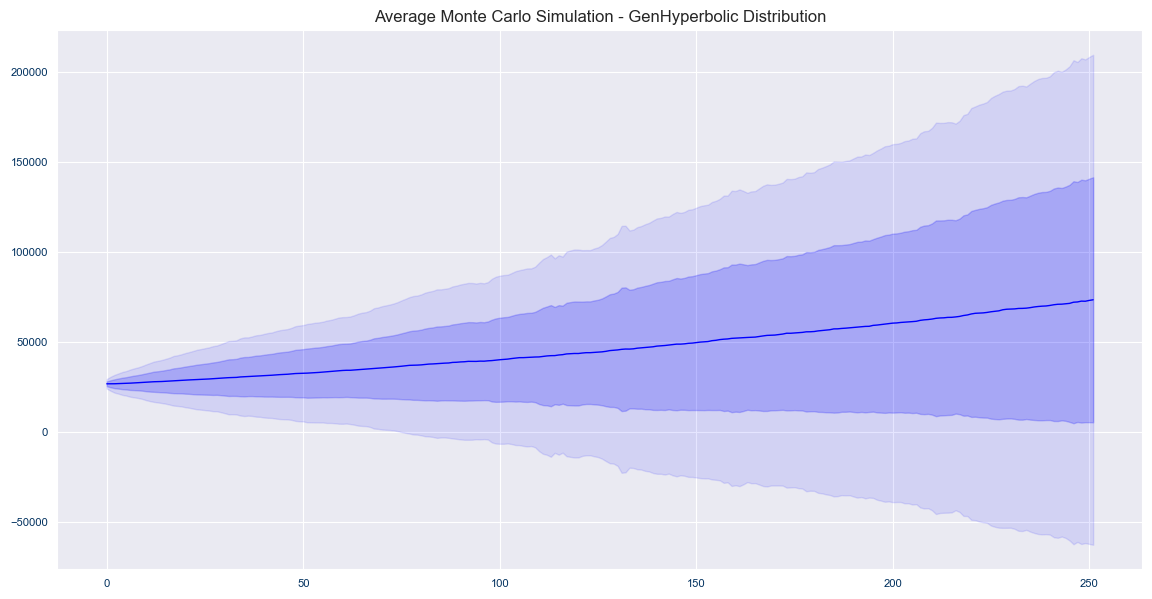

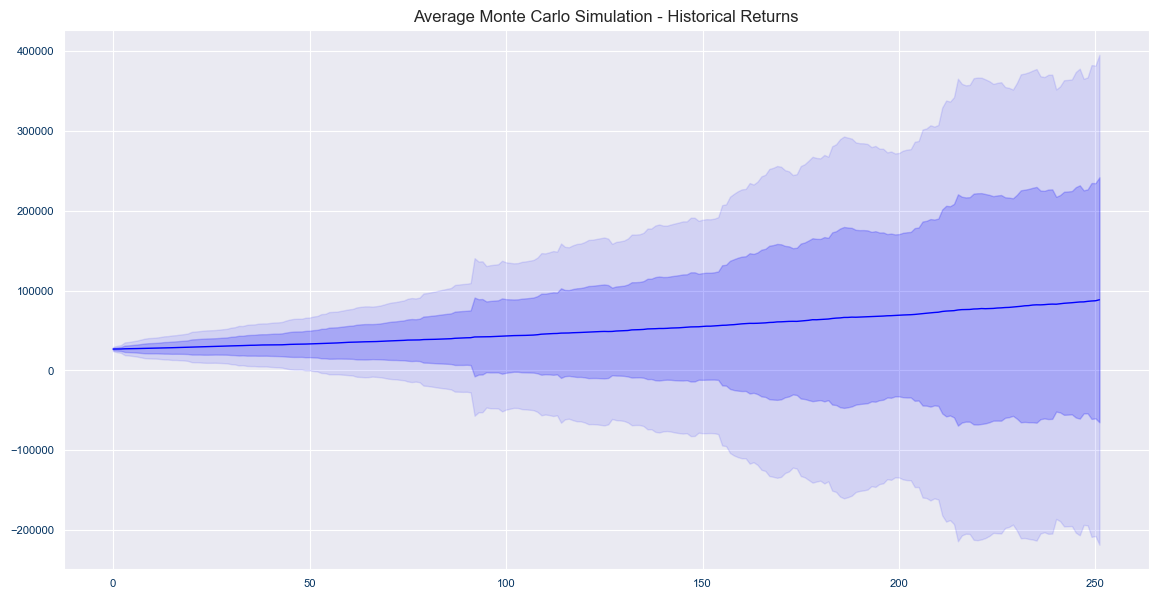

In [266]:
avg_prices_gh = np.mean(sim_prices_gh, axis=1)
std_dev_gh = np.std(sim_prices_gh, axis=1)
avg_prices_hist = np.mean(sim_prices_hist, axis=1)
std_dev_hist = np.std(sim_prices_hist, axis=1)

plt.figure(figsize=(14,7))
plt.plot(avg_prices_gh, color='blue')
plt.fill_between(range(n_days), avg_prices_gh - std_dev_gh, avg_prices_gh + std_dev_gh, color='blue', alpha=0.2)
plt.fill_between(range(n_days), avg_prices_gh - 2*std_dev_gh, avg_prices_gh + 2*std_dev_gh, color='blue', alpha=0.1)
plt.title('Average Monte Carlo Simulation - GenHyperbolic Distribution')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(avg_prices_hist, color='blue')
plt.fill_between(range(n_days), avg_prices_hist - std_dev_hist, avg_prices_hist + std_dev_hist, color='blue', alpha=0.2)
plt.fill_between(range(n_days), avg_prices_hist - 2*std_dev_hist, avg_prices_hist + 2*std_dev_hist, color='blue', alpha=0.1)
plt.title('Average Monte Carlo Simulation - Historical Returns')
plt.show()
